In [6]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import PIL.Image as pil

## Sobel Edge Detection 

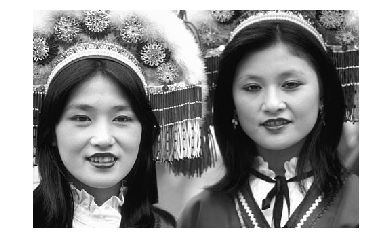

In [7]:
img = plt.imread('image2.jpg')
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.show()

In [9]:
def conv(img, kernel):
    'Applies a 3x3 kernel to a given image'
    
    # kernel shape
    m, n = kernel.shape[0:2]
    
    # Pad image so the output remains the same dimensions as the input
    img = np.pad(img, pad_width = (m // 2, n // 2), mode = 'constant', constant_values=0.0)
    
    # Valid convolution coords
    valid_y = img.shape[0] - m + 1
    valid_x = img.shape[1] - n + 1
    
    # Create empty image matrix
    new_image = np.empty((valid_y, valid_x))
    
    # Convolve kernel over image
    for i in range(valid_y):
        for j in range(valid_x):
            
            # Compute dot product of of 3x3 area in image against kernel and add the 9 values to get convolution output
            new_image[i, j] = np.sum(img[i:i+m, j:j+n] * kernel)
    
    return new_image 

In [10]:
def sobel(filename, threshold, save_files=[]):
    'Applies the sobel edge detector to an image'
    
    # Load image as grayscale
    img = pil.open(filename).convert('L')
    img = np.array(img)
    
    # Create sobel kernels
    kx = np.array([1, 0, -1, 2, 0, -2, 1, 0, -1]).reshape((3,3))
    ky = kx.transpose()
    
    # Apply sobel kernels in x and y direction
    Ix = conv(img, kx)
    Iy = conv(img, ky)
    
    # Save x and y gradients 
    if len(save_files) == 3:
        plt.imsave(save_files[0], Ix, cmap='gray')
        plt.imsave(save_files[1], Iy, cmap='gray')
    else:
        print('Provide the file names to save the x and y direction edges to')
    
    # Combine x and y components
    magnitude = np.sqrt(np.power(Ix, 2) + np.power(Iy, 2))
    
    # Apply threshholding 
    final_edges = np.where(magnitude >= threshold, magnitude, 0)
    
    # Save final edges
    if len(save_files) == 3:
        plt.imsave(save_files[2], final_edges, cmap='gray')
    else:
        print('Provide a file name to save the final edge detections to')
    
    return Ix, Iy, final_edges

Running sobel algorithm with a threshold of 100

In [11]:
x, y, final = sobel('image2.jpg', threshold = 100, save_files=['x_comp.jpg', 'y_comp.jpg', 'final_edges.jpg'])

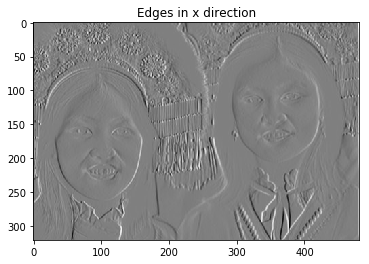

In [12]:
plt.imshow(x, cmap='gray')
plt.title('Edges in x direction')
plt.show()

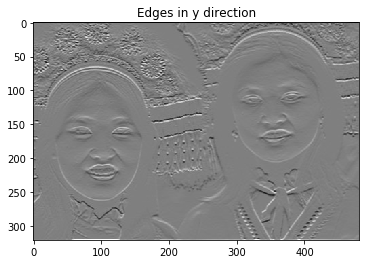

In [13]:
plt.imshow(y, cmap='gray')
plt.title('Edges in y direction')
plt.show()

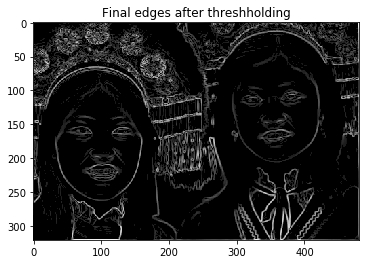

In [14]:
plt.imshow(final, cmap='gray')
plt.title('Final edges after threshholding')
plt.show()

## Harris Corner Detection

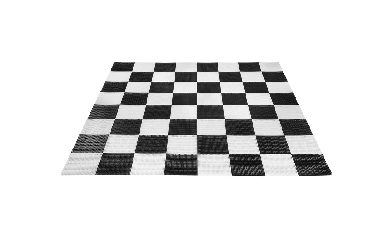

In [15]:
img = plt.imread('input_hcd1.jpg')
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.show()

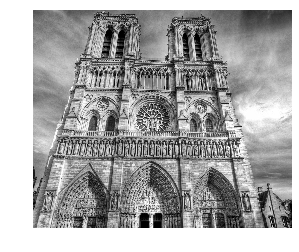

In [16]:
img = plt.imread('input_hcd2.jpg')
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.show()

In [67]:
def gaussian_blur(img, kernel_size):
    'Blurs an image using a gausian kernel of given size'
    
    # Get standard deviation of image
    sigma = np.std(img)
    
    # Create gaussian kernel of specified shape
    kernel = np.empty(shape = (kernel_size, kernel_size))
    
    # Creating kernel with gaussian function
    for i in range(kernel_size):
        for j in range(kernel_size):
            
            # Gaussian function
            a = 2 * np.pi * (sigma ** 2)
            b = np.exp(-(j ** 2 + i ** 2) / (2 * sigma ** 2))
            kernel[i, j] = (1 / a) * b
      
    # Convolve kernel to blur image
    output = conv(img, kernel)
        
    return output

In [68]:
def harris_corners(filename, k, window_size, threshold, save_file=None):
    'Applies the harris corner detector to an image'
    
    # Load image as grayscale
    img = pil.open(filename).convert('L')
    
    # Create 3 channel output image so we can mark corners in blue
    new_image = np.array(img.convert('RGB'))
    
    img = np.array(img)
    height, width = img.shape[0:2]
    
    # Blur image with 3x3 gaussian kernel
    img = gaussian_blur(img, 3)
    
    # Create sobel kernels
    kx = np.array([1, 0, -1, 2, 0, -2, 1, 0, -1]).reshape((3,3))
    ky = kx.transpose()
    
    # Apply sobel kernels in x and y direction
    Ix = conv2(img, kx)
    Iy = conv2(img, ky)
    
    # Computer pixel wise products of image gradients
    Ixx = Ix * Ix
    Iyy = Iy * Iy
    Ixy = Ix * Iy
    
    # Calculate sum of squares using window function
    w = np.ones(shape=(window_size, window_size))
    Sxx = conv2(Ixx, w)
    Syy = conv2(Iyy, w)
    Sxy = conv2(Ixy, w)
    
    # Array to hold harris responses
    responses = np.zeros(shape=(height,width))
    
    # Ensures calculated corner points are centered in window
    offset = window_size // 2
    
    # Compute the M matrix and response value for each pixel
    for i in range(offset, height - offset):
        for j in range(offset, width - offset):
            
            # Create M matrix
            M = np.array([Sxx[i, j], Sxy[i, j], Sxy[i,j], Syy[i, j]]).reshape((2,2))
            
            # Calculate trace
            trace = M[0,0] + M[1,1]
            
            # Calculate determinant = ad - bc
            det = M[0,0] * M[1,1] - M[0, 1] * M[1, 0]
            
            # Calculate corner response values
            r = det - k * trace ** 2
            
            responses[i, j] = r
    
    # Threshold R values 
    new_image[responses > threshold * responses.max()] = [0,0,255]
    
    # Save corners
    if save_file is not None:
        plt.imsave(save_file, new_image, cmap='gray')
    else:
        print('Provide a file name to save the final corner detections to')
    
    return new_image

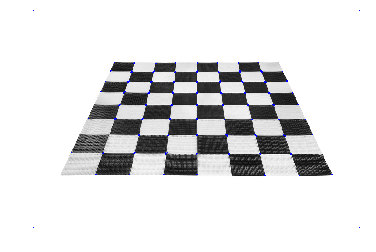

In [74]:
corners = harris_corners('input_hcd1.jpg', k = 0.04, window_size = 3, threshold = 0.01, save_file = 'hcd_output1.jpg')
plt.imshow(corners)
plt.axis('off')
plt.show()

### Attempting a few different k, window size, and threshold values 

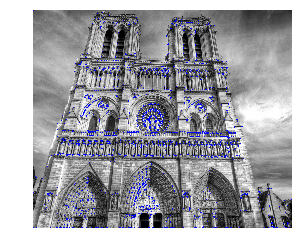

In [75]:
corners = harris_corners('input_hcd2.jpg', k = 0.06, window_size = 3, threshold = 0.01)
plt.imshow(corners)
plt.axis('off')
plt.show()

Provide a file name to save the final corner detections to


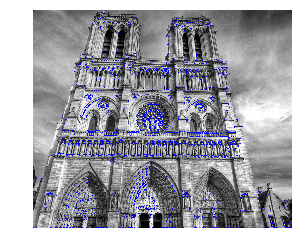

In [71]:
corners = harris_corners('input_hcd2.jpg', k = 0.04, window_size = 3, threshold = 0.01)
plt.imshow(corners)
plt.axis('off')
plt.show()

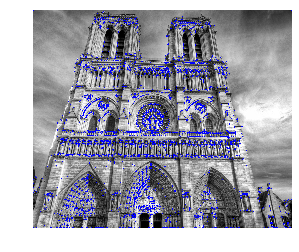

In [76]:
corners = harris_corners('input_hcd2.jpg', k = 0.06, window_size = 3, threshold = 0.005, save_file = 'hcd_output2.jpg')
plt.imshow(corners)
plt.axis('off')
plt.show()

Provide a file name to save the final corner detections to


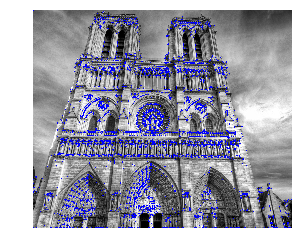

In [73]:
corners = harris_corners('input_hcd2.jpg', k = 0.04, window_size = 3, threshold = 0.005)
plt.imshow(corners)
plt.axis('off')
plt.show()